In [ ]:
import zipfile

from tensorflow.python.keras.utils.version_utils import callbacks

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os 

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
    

In [ ]:
#resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
class WrappedKerasLayer(tf.keras.layers.Layer):
    def __init__(self, hub_layer):
        super(WrappedKerasLayer, self).__init__()
        self.hub_layer = hub_layer
    
    def call(self, inputs):
        return self.hub_layer(inputs)

def create_model(model_url, num_classes=10):
    """
    Takes TensorFlow Hub URL and creates a Keras sequential model with it
    :param model_url: Tensorflow hub feature extraction URL 
    :param num_classes: should be number of target classes 
    :return: an uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
    """
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False,  # freeze the already learned patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))
    
    wrapped_layer = WrappedKerasLayer(feature_extractor_layer)
    
    print(type(feature_extractor_layer))
    
    m = tf.keras.Sequential([
        wrapped_layer,
        layers.Dense(num_classes, activation='softmax', name="output_layer")
    ])
    m.build((None, ) + IMAGE_SHAPE + (3,))
    
    return m

In [ ]:
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent, 
                 epochs=5, 
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnet50v2')]
                 )

In [ ]:
# Epoch 5/5
# 24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9077 - loss: 0.4150 - val_accuracy: 0.9333 - val_loss: 0.3327


# wow

In [60]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Return Separate loss curves for training and validation metrics
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    plt.figure()
    epochs = range(len(history.history['accuracy']))
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

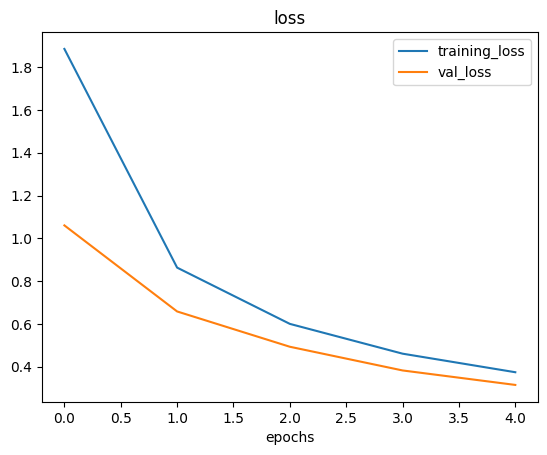

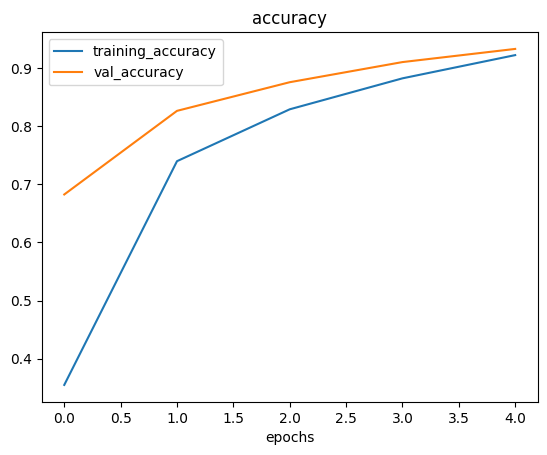

In [62]:
plot_loss_curves(resnet_history)

In [ ]:
efficientnet_model = create_model(efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.summary()

efficientnet_model.compile(optimizer='adam', 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

history_efficientnet = efficientnet_model.fit(train_data_10_percent, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficientnet')])

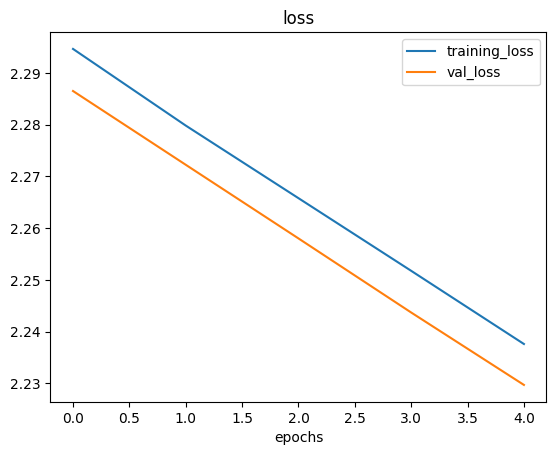

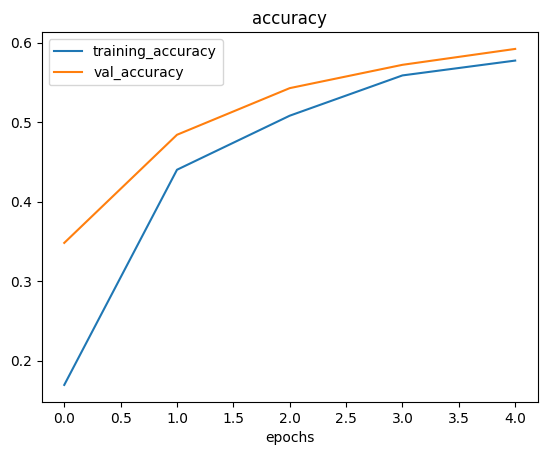

In [61]:
plot_loss_curves(history_efficientnet)

In [1]:
# as is transfer learning - no training
# feature extraction e.g. efficientnet (ege EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)

# Fine-tuning - use prelearned patterns of existing model and fine-tune many or all underlying layers (including new output)

In [2]:
!pip install tensorboard


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!tensorboard dev upload --logdir ./tensoftlow_hub/ --name "EfficientNetB0 vs ResNet50V2" --description "Comparing two different TF Hub feature extraction model arhcitectures" --one_shot

2025-03-05 09:40:39.484459: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 09:40:47.795281: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.
